### Libraries

In [79]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from joblib import Parallel, delayed
from datetime import datetime
import pandas as pd
import os
import re
from scipy.interpolate import griddata
from scipy.integrate import quad

### path to save the data
path_to_save = '/data/zenari/FH/data/'
###path to save the plots
path_to_save_pltos = 'data/zenari/FH/results/'

### Utils

In [80]:
#function to simulate the FH model
@nb.njit
def FH(params, N, N_steps, dt, ic = None, Z = None):

    #parameters of the model
    epsilon, psi, delta, nu, alpha, beta, gamma, mu, sigma = params

    #initial conditions
    if ic is None:
        x_0 = np.random.randn(N)
        y_0 = np.random.randn(N)
    else:
        #initial conditions
        x_0, y_0 = ic

    #quenched current
    if Z is None:
        Z = np.random.randn(N)

    #observable initialization
    X = np.zeros(N_steps)  

    #initialization of vectors
    x = np.zeros((N, N_steps))
    y = np.zeros((N, N_steps))

    #random initial conditions
    x[:, 0] = x_0
    y[:, 0] = y_0

    #temporal integration with eulero
    for t in range(1, N_steps):
        for n in nb.prange(N):
            X[t-1] = np.mean(x[:, t-1])   
            x[n, t] = x[n, t-1] + dt*(psi*x[n, t-1] + delta*(x[n, t-1])**3 + nu*y[n, t-1] + mu + sigma*Z[n] +epsilon*X[t-1])
            y[n, t] = y[n, t-1] + dt*alpha*(x[n, t-1] + beta*y[n, t-1]+gamma)
    X[N_steps-1] = np.mean(x[:, N_steps-1])
            
    return x, y, X, Z

#function to estimate the limit cycle of the -FH model
def naive_estimate_limit_cycle(x, y, dr = 0.01):
    #computing the averages
    X = np.mean(x, axis = 0)
    Y = np.mean(y, axis = 0)

    #computing the limit cycle
    limit_cycle = []

    #maximum number of steps
    N_steps = X.shape[0]
    
    for kk in range(2, N_steps):
        if np.sqrt((X[-kk]-X[-1])**2+(Y[-kk]-Y[-1])**2)<dr and kk>100:
            break
        else:
            limit_cycle.append([X[-kk], Y[-kk]])

    limit_cycle = np.array(limit_cycle)

    return  None, limit_cycle[:, 0], limit_cycle[:, 1]



def estimate_limit_cycle(x, y, phase_bins=1000, window_size=5):
    # Step 1: Compute the phase of each oscillator
    theta = np.arctan2(y, x)  # Phase in range [-π, π]
    
    # Step 2: Wrap phases into [0, 2π]
    theta = (theta + 2 * np.pi) % (2 * np.pi)
    
    # Step 3: Define phase grid
    phi_grid = np.linspace(0, 2 * np.pi, phase_bins, endpoint=False)

    # Step 4: Compute mean x and y per phase bin
    mean_x = np.zeros(phase_bins)
    mean_y = np.zeros(phase_bins)

    delta_theta = 2 * np.pi / phase_bins
    for i, phi in enumerate(phi_grid):
        mask = (theta >= phi) & (theta < phi + delta_theta)  # Select oscillators in bin
        if np.any(mask):  # Avoid empty bins
            mean_x[i] = np.mean(x[mask])
            mean_y[i] = np.mean(y[mask])
        else:
            mean_x[i] = np.nan
            mean_y[i] = np.nan

    mean_x = mean_x[mean_x != np.nan]
    mean_y = mean_y[mean_y != np.nan]

    return phi_grid, mean_x, mean_y


#### function to plot the FH model
def plotFH(t, xs, ys, X, Z, params, path_to_save_plots = None):

    x = np.mean(xs, axis = 0)
    y = np.mean(ys, axis = 0)

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    #### plot the density plot of the points
    hist = ax[0].hist2d(xs.flatten(), ys.flatten(), bins = 100, density = True, cmap='plasma')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    fig.colorbar(hist[3], ax=ax[0], label = 'Density of points')


    ### plot the trajectory of the mean values in the phase space
    sc = ax[1].scatter(x, y, c=t, cmap='plasma', marker = '.')
    fig.colorbar(sc, ax=ax[1], label = 'Time')
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y')


    ### plot the time-series of the observable
    n_iters= np.min([10, X.shape[0]])
    for i in range(X.shape[0])[-n_iters:]:
        ax[2].plot(t, X[i, :], label = 'it. %d' % i)
 
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('X')
    ax[2].legend()

    fig.suptitle(r'FH simulation - $\epsilon=%.2f$' % params[0])

    if path_to_save_plots is not None:
        plt.savefig(path_to_save_plots)
        plt.close()
    else:
        plt.show()


### function to plot the limit cycle and the phase space
def plot_limit_cycle(x, y, lc_x, lc_y, params, path_to_save_plots=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    hist = ax.hist2d(x.flatten(), y.flatten(), bins=100, cmap='plasma', density=True)  # Plot density of points
    fig.colorbar(hist[3], ax=ax, label='Density of points')
    ax.plot(lc_x, lc_y, color='aqua', linewidth=2)  # Plot limit cycle
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Limit cycle and phase space point density')

    plt.tight_layout
    fig.suptitle(r'FH - Limit cycle - $\epsilon=%.2f$' % params[0])

    if path_to_save_plots is not None:
        plt.savefig(path_to_save_plots)
        plt.close()
    else:
        plt.show()


#function to estimate the baricenter of the -FH model as the center for epsilon = 0
def estimate_baricenterFH(params, N_average = 1000, N = 1000, N_steps = 10_000, dt = 0.01):

    #setting the coupling epsilon to zero
    params = list(params)
    params[0] = 0
    params = tuple(params)
    
    #simulating the model with epsilon = 0
    x, y, X, Z  = FH(params, N, N_steps + N_average, dt)

    #computing the geometric center
    X_c = np.mean(x[:, -N_average:])
    Y_c = np.mean(y[:, -N_average:])

    return X_c, Y_c


### function to estimate the geometric center of a limit cycle
def estimate_geometric_center(x, y):
    """Estimate the geometric center of a closed limit cycle using Green's theorem."""
    x = np.asarray(x)
    y = np.asarray(y)

    # Ensure the cycle is closed
    x = np.append(x, x[0])
    y = np.append(y, y[0])

    # Compute the enclosed area A
    A = 0.5 * np.sum(x[:-1] * y[1:] - x[1:] * y[:-1])

    # Compute centroid using Green's theorem
    Cx = (1 / (6 * A)) * np.sum((x[:-1] + x[1:]) * (x[:-1] * y[1:] - x[1:] * y[:-1]))
    Cy = (1 / (6 * A)) * np.sum((y[:-1] + y[1:]) * (x[:-1] * y[1:] - x[1:] * y[:-1]))

    return [Cx, Cy]


### functions that enter the computation of the instable point
def f(x, params):
    epsilon, psi, delta, nu, alpha, beta, gamma, mu, sigma = params
    return -((psi+epsilon)*x+delta*x**3+mu)/(nu)
def g(x, params):
    epsilon, psi, delta, nu, alpha, beta, gamma, mu, sigma = params
    return -x/beta - gamma/beta

### function to find the intersection between two null-clines
def find_intersections(g, f, a, b, params, max_roots=3, num_points=1000):
    # Define h(x) = g(x, params) - f(x, params)
    def h(x):
        return g(x, params) - f(x, params)

    # Generate x values and evaluate h(x)
    x_vals = np.linspace(a, b, num_points)
    h_vals = h(x_vals)

    # Find sign changes (possible roots)
    sign_changes = np.where(np.sign(h_vals[:-1]) != np.sign(h_vals[1:]))[0]
    roots = []

    for idx in sign_changes[:max_roots]:  # Limit to max_roots
        x_root = brentq(h, x_vals[idx], x_vals[idx + 1])  # Solve h(x) = 0
        y_root = g(x_root, params)  # Compute corresponding y-value
        roots.append((x_root, y_root))

    return roots


### function to plot the limit cycle and the interest points
def plot_interest_points(lc_x, lc_y, baricenter, geometric_center, unstable_points, xs, fs, gs, params, path_to_save_plots = None):

    plt.figure(figsize=(6, 6))
    plt.plot(lc_x, lc_y, label = 'Limit cycle')
    plt.plot(xs, fs, label = r'$y = f(x)$')
    plt.plot(xs, gs, label = r'$y = -\frac{x}{\beta} - \frac{\gamma}{\beta}$')
    plt.scatter([p[0] for p in unstable_points], [p[1] for p in unstable_points], color = 'red', marker= 'x', label = 'Unstable points')
    plt.scatter(baricenter[0], baricenter[1], marker = 'x', label = 'Baricenter')
    plt.scatter(geometric_center[0], geometric_center[1], marker = 'x', label = 'Geometric center')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(r'FH - Limit cycle and interest points - $\epsilon=%.2f$' % params[0])
    plt.legend()
    
    if path_to_save_plots is not None:
        plt.savefig(path_to_save_plots)
        plt.close()
    else:
        plt.show()


### function to compute the limit cycle and the interest points parallelized
def limit_cycle(params, hyperparams, path_to_save_data=None, path_to_save_plots=None):
    
    #unpacking the parameters
    epsilon, *fixed_params = params
    N, N_transient, N_stationarity, dt, theta_bins, window_size, dr_lc = hyperparams

    #computing the  simulation
    x, y, X, Z = FH(params, N, N_transient + N_stationarity, dt)

    #estimating the limit cycle
    if window_size is not None:
        phi_grid, lc_x, lc_y = estimate_limit_cycle(x[:, N_transient:], y[:, N_transient:], theta_bins, window_size)
    elif dr_lc is not None:
        _, lc_x, lc_y = naive_estimate_limit_cycle(x[:, N_transient:], y[:, N_transient:], dr = dr_lc)
    else:
        _, lc_x, lc_y = naive_estimate_limit_cycle(x[:, N_transient:], y[:, N_transient:])
   

    #computing interest points
    baricenter = estimate_baricenterFH(params, N_average=1000, N=N, N_steps=N_stationarity, dt=dt)
    geometric_center = estimate_geometric_center(lc_x, lc_y)
    unstable_points = find_intersections(g, f, -2, 2, params)

    #computing the null-clines
    xs = np.linspace(-2, 2, 1000)
    fs = f(xs, params)
    gs = g(xs, params)
  
    #saving the data
    if path_to_save_data is not None:
        np.savez(path_to_save_data+'limit_cycle_epsilon{}'.format(epsilon), lc_x=lc_x, lc_y=lc_y, baricenter=baricenter, geometric_center=geometric_center, unstable_points=unstable_points, xs=xs, fs=fs, gs=gs)


    #saving the plots
    if path_to_save_plots is not None:
        #saving simulation
        plotFH(np.arange(N_stationarity)*dt, x[:, N_transient:], y[:, N_transient:], X[N_transient:], Z, params, path_to_save_plots+'limit_cycle_simulation_epsilon{}.png'.format(epsilon))
        #saving interest points
        plot_interest_points(lc_x, lc_y, baricenter, geometric_center, unstable_points, xs, fs, gs, params, path_to_save_plots+'limit_cycle_interest_points_epsilon{}.png'.format(epsilon))
        #saving limit cycle 
        plot_limit_cycle(x[:, N_transient:], y[:, N_transient:],lc_x, lc_y, params, path_to_save_plots+'limit_cycle_epsilon{}.png'.format(epsilon))

        
    return [params, hyperparams]


#function that return the return time given the limit cycle and the trajectory
def returning_time(limit_cycle, X, Y, N_steps, tau = 10, dr=0.01):

    #assembling the trajectory
    trajectory = np.array([X, Y]).T

    #computing the array of distances as a function of time
    distances = []
    for t in range(N_steps):
        distances.append(np.min(np.sqrt((trajectory[t, 0]-limit_cycle[:, 0])**2+(trajectory[t, 1]-limit_cycle[:, 1])**2)))
    distances = np.array(distances)

    #at each time returns 1 if the distance from limit cycle is smaller than dr
    track = np.zeros(N_steps)       
    for t in range(N_steps):
        if distances[t]<dr:
            track[t] = 1

    #counts the number of consecutive positive tracks, if > tau returns the time
    counter = 0
    for idx, tr in enumerate(track):
        if tr == 1:
            counter = counter + 1
            if counter == tau:
                break
        else:
            counter = 0
            
    return idx, distances, track

#function to compute the retuning time as first intersection with the limit cycle
def returning_time_first_intersection(limit_cycle, X, Y, N_steps, dr=0.01):
    
    #assembling the trajectory
    trajectory = np.array([X, Y]).T

    #computing the array of distances as a function of time
    for t in range(N_steps):
        d = np.min(np.sqrt((trajectory[t, 0]-limit_cycle[:, 0])**2+(trajectory[t, 1]-limit_cycle[:, 1])**2))
        if d<dr:
            break
        
    return t



#### Code to run all the simulations
def FH_control(input, path_to_save):
    ### unpack inputs
    params = input[0]
    N, N_transient, N_stationarity, dt, dr_lc, N_average, N_return, N_times = input[1]
    x0, y0, n = input[2]

    ### running a long  simulation
    x, y, X, Z = FH(params, N, N_transient + N_stationarity, dt)

    ### estimating the limit cycle
    _, lc_x, lc_y = naive_estimate_limit_cycle(x[:, N_transient:], y[:, N_transient:], dr = dr_lc)

    ### estimating the baricenter
    baricenter = estimate_baricenterFH(params, N_average=N_average, N=N, N_steps=N_transient, dt=dt)

    ### estimating the geometric center
    geometric_center = estimate_geometric_center(lc_x, lc_y)

    ### estimating the unstable points
    unstable_points = find_intersections(g, f, -2, 2, params)

    ### computing the null-clines
    xs = np.linspace(-2, 2, 1000)
    fs = f(xs, params)
    gs = g(xs, params)


    #vector to save the return times
    taus = []
    Xs_return = []
    Ys_return = []  

    ### running the controll simulation
    for kk in range(N_times):
        ### sampling a random configuration
        n_conf = np.random.randint(0, N_stationarity)

        #### choosing the i.c. as a translation
        ic = [x[:, N_transient+n_conf]-np.mean(x[:, N_transient+n_conf])+x0, y[:, N_transient+n_conf]-np.mean(y[:, N_transient+n_conf])+y0]

        ### running controll simulation
        x_ret, y_ret, X_ret, Z_ret = FH(params, N, N_return, dt, ic = ic, Z = Z)

        #computing the return time
        #return_time, distances, track = returning_time(np.array([lc_x, lc_y]).T, np.mean(x_ret, axis = 0), np.mean(y_ret, axis = 0), N_return, tau = 10, dr = dr_lc)
        return_time = returning_time_first_intersection(np.array([lc_x, lc_y]).T, np.mean(x_ret, axis = 0), np.mean(y_ret, axis = 0), N_return, dr = dr_lc)

        taus.append(return_time)
        Xs_return.append(np.mean(x_ret, axis = 0))
        Ys_return.append(np.mean(y_ret, axis = 0))

    taus = np.array(taus)
    Xs_return = np.array(Xs_return)
    Ys_return = np.array(Ys_return)

    #saving the results    
    np.savez(path_to_save+'data_epsilon{}_icx{}_icy{}_n{}'.format(params[0], x0, y0, n), 
             X = np.mean(x, axis = 0), Y = np.mean(y, axis = 0), 
             lc_x = lc_x, lc_y = lc_y, 
             baricenter = baricenter, geometric_center = geometric_center, unstable_points = unstable_points, 
             xs = xs, fs = fs, gs = gs, 
             taus = taus, Xs_return = Xs_return, Ys_return = Ys_return)
    

    return [params, [N, N_transient, N_stationarity, dt, dr_lc, N_average, N_return, N_times], taus, lc_x, lc_y, baricenter, geometric_center, unstable_points, xs, fs, gs]

## Running the simulations and saving the data

In [81]:
### FIXED PARAMETERS
psi = 1
delta = -1/3
nu = -1
alpha = 0.1
beta = -0.8
gamma = 0.7
mu = 0.6
sigma = 0.1


### COUPLING PARAMETER
epsilon_list = [0.1, 0.2, 0.3, 0.4, 0.5]

### CONTROLL
xs = np.linspace(-2.5, 2.5, 51 )
ys = np.linspace(-0.8, 2, 29)

### HYPERPARAMETERS
N = 1000
N_transient = 8000#40_000
N_stationarity = 2000#10_000
N_average = 2000#10_000
N_return =2000#10_000
dt = 0.05#0.01
dr_lc = 0.03


#### STATISTIC
N_trials = 1
N_times = 100

inputs = []
for epsilon in epsilon_list:
    for x0 in xs:
        for y0 in ys:
            for n in range(N_trials):
                inputs.append(((epsilon, psi, delta, nu, alpha, beta, gamma, mu, sigma), [N, N_transient, N_stationarity, dt, dr_lc,  N_average, N_return, N_times], [x0, y0, n]))


#### Running the parallelized simulations
print('Number of simulations: %d' % len(inputs))

Number of simulations: 7395


## Analysis of the simulations

In [82]:
def simulation_analysis(file, path_to_control_plots=None):

    ### loading the data
    data = np.load(path_to_data + file)

    ### inferring the parameters from the file name
    pattern_epsilon = re.compile('epsilon(.*?)_')
    epsilon = float(pattern_epsilon.findall(file)[0])

    pattern_icx = re.compile('icx(.*?)_')
    icx = float(pattern_icx.findall(file)[0])

    pattern_icy = re.compile('icy(.*?)_')
    icy = float(pattern_icy.findall(file)[0])

    pattern_n = re.compile('_n(.*?).npz')
    n = int(pattern_n.findall(file)[0])
    
    ### unpacking the data
    X = data['X']
    Y = data['Y']
    lc_x = data['lc_x']
    lc_y = data['lc_y']
    baricenter = data['baricenter']
    geometric_center = data['geometric_center']
    unstable_points = data['unstable_points']
    xs = data['xs']
    fs = data['fs']
    gs = data['gs']
    taus = data['taus']
    Xs_return = data['Xs_return']
    Ys_return = data['Ys_return']

    ### producing some plots to controll the simulations
    if path_to_control_plots is not None:
        plot_simulation(epsilon, icx, icy,n,  t, X, Y, lc_x, lc_y, xs, fs, gs, baricenter, geometric_center, unstable_points, Xs_return, Ys_return, taus, path_to_save_plots = path_to_control_plots + file[:-4] + '.png')

    ### analyzing the return times
    taus = np.array(taus)[taus*dt < tau_max]*dt
    mean_tau = np.mean(taus)
    std_tau = np.std(taus)

    ### adding to the df
    return [epsilon, icx, icy, n, mean_tau, std_tau, lc_x, lc_y, baricenter, geometric_center, unstable_points, xs, fs,gs, Xs_return, Ys_return, taus]

In [83]:
#path to data
path_to_data = '/data/zenari/FH/data/'
path_to_results = '/data/zenari/FH/results/'

#parameters of simulations
dt = 0.05
tau_max = 99

#listing the files
files = os.listdir(path_to_data)
print('Number of files:', len(files))

Number of files: 7395


In [84]:
print('Number of files:', len(files))

results = Parallel(n_jobs=-1, verbose = 11)(delayed(simulation_analysis)(file) for file in files)

df = pd.DataFrame(data = results, columns = ['epsilon', 'icx', 'icy', 'n', 'mean_tau', 'std_tau', 'lc_x', 'lc_y', 'baricenter', 'geometric_center', 'unstable_points', 'xs', 'fs', 'gs', 'Xs_return', 'Ys_return', 'taus'])

#df.to_csv(path_to_results + 'results.csv', index = False)

Number of files: 7395


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | el

In [88]:
#Loading the final df
#df = pd.read_csv(path_to_results + 'results.csv')

print('DF length:', len(df))
df_cleaned = df[df['mean_tau'] < tau_max]
df_cleaned = df_cleaned.dropna(subset = ['mean_tau'])
print('DF length after cleaning:', len(df_cleaned))
df_cleaned.head()

DF length: 7395
DF length after cleaning: 7395


,epsilon,icx,icy,n,mean_tau,std_tau,lc_x,lc_y,baricenter,geometric_center,unstable_points,xs,fs,gs,Xs_return,Ys_return,taus
0,0.1,-2.4,-0.8,0,7.6100,0.060000,"[-1.5864713551151424, -1.5899623947239288, -1....","[0.11947737984140927, 0.12442489138055088, 0.1...","[-0.26315152961144633, 0.5566006592136183]","[-0.129526101031221, 0.7095471956549547]","[[-0.7797573234032937, -0.09969665425411722]]","[-2.0, -1.995995995995996, -1.991991991991992,...","[1.0666666666666664, 1.0550870977537214, 1.043...","[-1.625, -1.619994994994995, -1.61498998998999...","[[-2.4000000000000012, -2.231308986410989, -2....","[[-0.7999999999999989, -0.8052999999999989, -0...","[7.65, 7.65, 7.6000000000000005, 7.60000000000..."
1,0.1,-2.4,0.4,0,1.2535,0.210980,"[-1.6375399553193237, -1.6410216241146753, -1....","[0.1927720784575872, 0.19827026764875572, 0.20...","[-0.2665064670188887, 0.5535593164541931]","[-0.13043234552601804, 0.7077781069125371]","[[-0.7797573234032937, -0.09969665425411722]]","[-2.0, -1.995995995995996, -1.991991991991992,...","[1.0666666666666664, 1.0550870977537214, 1.043...","[-1.625, -1.619994994994995, -1.61498998998999...","[[-2.400000000000001, -2.201389980700263, -2.0...","[[0.4000000000000001, 0.3898999999999996, 0.38...","[1.1500000000000001, 1.1500000000000001, 1.35,..."
2,0.1,-2.4,-0.5,0,7.9955,0.081883,"[-1.5426764100734194, -1.5461835340660943, -1....","[0.06284664548974943, 0.06734695096393571, 0.0...","[-0.26239333640734547, 0.5594837362323927]","[-0.12749405113225482, 0.7107140203374009]","[[-0.7797573234032937, -0.09969665425411722]]","[-2.0, -1.995995995995996, -1.991991991991992,...","[1.0666666666666664, 1.0550870977537214, 1.043...","[-1.625, -1.619994994994995, -1.61498998998999...","[[-2.4000000000000004, -2.245593030110028, -2....","[[-0.49999999999999967, -0.5064999999999996, -...","[7.95, 8.0, 7.95, 7.95, 8.05, 8.0, 8.05, 8.0, ..."
3,0.1,-2.4,0.7,0,0.9280,0.172383,"[-1.5770268539290255, -1.5805260242628514, -1....","[0.10891103851842586, 0.1137687436141968, 0.11...","[-0.2672935663975331, 0.5543777639624647]","[-0.1282255388927974, 0.7111487054237584]","[[-0.7797573234032937, -0.09969665425411722]]","[-2.0, -1.995995995995996, -1.991991991991992,...","[1.0666666666666664, 1.0550870977537214, 1.043...","[-1.625, -1.619994994994995, -1.61498998998999...","[[-2.3999999999999977, -2.306259979914555, -2....","[[0.6999999999999991, 0.6886999999999998, 0.67...","[1.0, 1.0, 0.9500000000000001, 1.0, 1.0, 1.0, ..."
4,0.1,-2.4,0.5,0,1.1410,0.156585,"[-1.5634214612967903, -1.5669232792196, -1.570...","[0.09053889844761173, 0.0952545329756122, 0.10...","[-0.26688353135973497, 0.5503185115668555]","[-0.12632621136001435, 0.710657670889859]","[[-0.7797573234032937, -0.09969665425411722]]","[-2.0, -1.995995995995996, -1.991991991991992,...","[1.0666666666666664, 1.0550870977537214, 1.043...","[-1.625, -1.619994994994995, -1.61498998998999...","[[-2.3999999999999986, -2.295723056476963, -2....","[[0.4999999999999996, 0.48949999999999994, 0.4...","[1.2000000000000002, 1.25, 1.2000000000000002,..."


#### Heatmaps

In [89]:
#set plot size
plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 10   # Default font size for text
plt.rcParams['axes.titlesize'] = 10   # Font size for axes titles
plt.rcParams['axes.labelsize'] = 11 # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 9 # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 9 # Font size for y tick labels


#set-up the font as in latex
plt.rcParams.update({
    "font.size": 10,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True
})

#available styles
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
#! pip install palettable
import palettable.scientific.sequential as dmftaffa

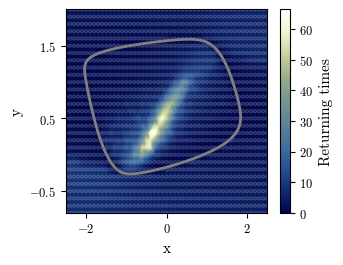

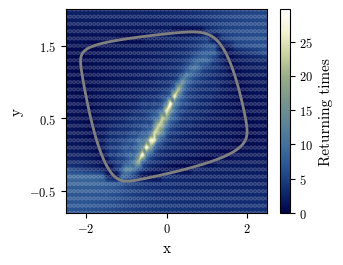

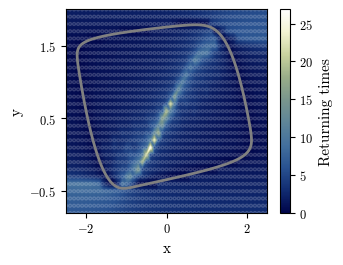

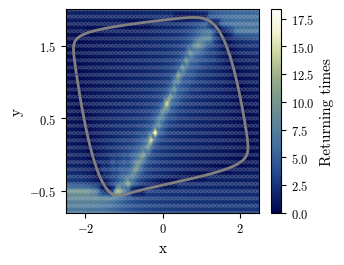

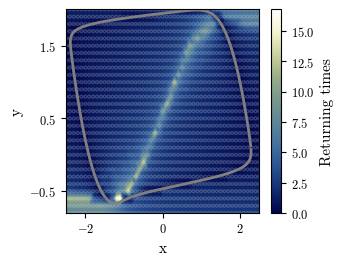

In [184]:
epsilon_list = df['epsilon'].unique()

for epsilon in epsilon_list:

    df_eps = df_cleaned[df_cleaned['epsilon'] == epsilon]

    n = np.random.randint(0, len(df_eps))

    lc_x = df_eps.iloc[n]['lc_x']
    lc_y = df_eps.iloc[n]['lc_y']

    baricenter = df_eps.iloc[n]['baricenter']
    geometric_center = df_eps.iloc[n]['geometric_center']
    unstable_points = df_eps.iloc[n]['unstable_points']

    icx = df_eps.iloc[n]['icx']
    icy = df_eps.iloc[n]['icy']

    x_f = df_eps.iloc[n]['xs']
    fs = df_eps.iloc[n]['fs']
    gs = df_eps.iloc[n]['gs']


    x_low = -2.5
    x_high = 2.5
    y_low = -0.8
    y_high = 2

    query_x = np.linspace(x_low, x_high, 400)
    query_y = np.linspace(y_low, y_high, 400)

    query_grid = np.meshgrid(query_x, query_y)

    xs = df_eps['icx']
    ys = df_eps['icy']
    values = df_eps['mean_tau']
    
    grid_values = griddata((xs, ys), values, (query_grid[0], query_grid[1]), method='linear')


    plt.figure(figsize=(8.9/2.54, 7/2.54))
    sc = plt.imshow(grid_values, extent=(x_low, x_high, y_low, y_high), origin='lower', cmap=dmftaffa.Davos_10.mpl_colormap, aspect='auto')

# Scatter points with improved colors
    #plt.scatter(baricenter[0], baricenter[1], marker='.', color='orange', s=100, label=r'$\epsilon = 0$ center')  # Brighter cyan
    #plt.scatter(geometric_center[0], geometric_center[1], marker='.', color='lawngreen', s=100, label=r'geometric center')  # Rich golden yellow
    #plt.scatter([p[0] for p in unstable_points], [p[1] for p in unstable_points], color='firebrick', marker='.', s=100, label='Unstable point')  # Stronger red

    # Nullclines with more distinct colors
    #plt.plot(x_f, gs, color='firebrick', linewidth=2, alpha=1, label=r'Nullcline $\frac{dy}{dt}=0$')  # Deep magenta
    #plt.plot(x_f, fs, color='firebrick', linewidth=2, alpha=1, label=r'Nullcline $\frac{dx}{dt} = 0$')  # Rich orange

    # Colorbar
    plt.colorbar(sc, label='Returning times')

    # Scatter original points with improved edge contrast
    plt.scatter(xs, ys, c=values, s = 4, edgecolors='white', alpha=0.2, cmap=dmftaffa.Davos_10.mpl_colormap)  # Increased alpha for more visibility

    # Limit cycle with refined color
    plt.plot(lc_x, lc_y, color='grey', linewidth=2, label='Limit cycle')  # Softer but distinct teal

    # Labels and title
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks([-2, 0, 2])
    plt.yticks([-0.5, 0.5, 1.5])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-0.8, 2)
    #plt.title(r'Interpolated Heatmap $\epsilon$={}'.format(epsilon))
    #plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig(path_to_results + 'heatmap_grid_epsilon{}.pdf'.format(epsilon), bbox_inches='tight', pad_inches=0.1, dpi=300)

   